In [11]:
import os, random, shutil
from tqdm import tqdm

# source and destination dirs
src_root = "/storage/no_amd_augmented"
dst_root = "/storage/dataset_balanced"

# desired count per class
target_count = 10000

# make destination dir
os.makedirs(dst_root, exist_ok=True)

for cls in os.listdir(src_root):
    src_cls = os.path.join(src_root, cls)
    dst_cls = os.path.join(dst_root, cls)
    os.makedirs(dst_cls, exist_ok=True)

    images = os.listdir(src_cls)
    random.shuffle(images)

    if len(images) > target_count:
        selected = images[:target_count]   # downsample
    else:
        selected = images                  # keep all if < 10k

    for img in tqdm(selected, desc=f"Copying {cls}"):
        shutil.copy(os.path.join(src_cls, img), os.path.join(dst_cls, img))


Copying glaucoma: 100%|██████████| 10000/10000 [00:41<00:00, 242.58it/s]


/tmp/ipykernel_37/104394013.py:29: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


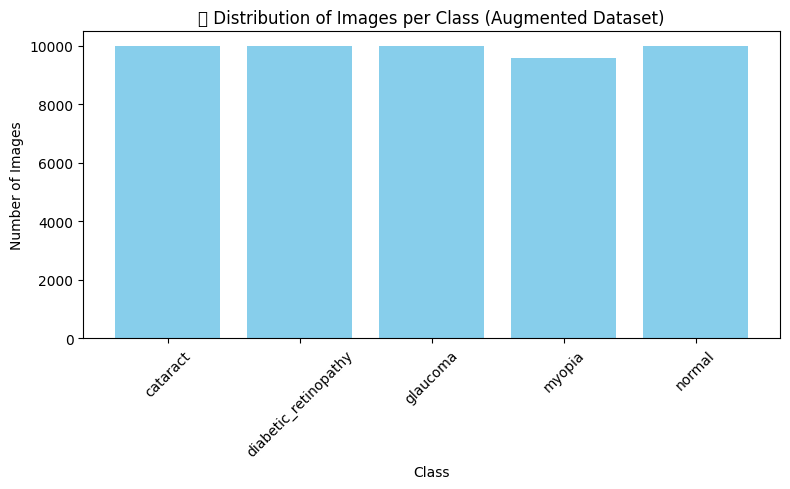

In [1]:
import os
import matplotlib.pyplot as plt

# Path to augmented dataset
augmented_path = "/storage/dataset_balanced"

# Count images per class
def count_images(folder_path):
    counts = {}
    for class_name in sorted(os.listdir(folder_path)):
        class_dir = os.path.join(folder_path, class_name)
        if os.path.isdir(class_dir):
            counts[class_name] = sum(
                len([f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
                for _, _, files in os.walk(class_dir)
            )
    return counts

# Compute counts
augmented_counts = count_images(augmented_path)

# Plot
plt.figure(figsize=(8, 5))
plt.bar(augmented_counts.keys(), augmented_counts.values(), color='skyblue')
plt.title("🧩 Distribution of Images per Class (Augmented Dataset)")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [1]:
import os
from PIL import Image
import tensorflow as tf
from tqdm import tqdm

2025-10-29 06:44:11.557714: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-29 06:44:11.594655: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-29 06:44:11.594697: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-29 06:44:11.595804: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-29 06:44:11.602214: I tensorflow/core/platform/cpu_feature_guar

In [2]:


# ==========================================
# 📁 DATASET CONFIGURATION
# ==========================================
data_dir = "/storage/dataset_balanced"
img_size = (224, 224)
batch_size = 64
seed = 123

# ✅ Split into train+val (85%) and test (15%)
train_val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.15,
    subset="training",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.15,
    subset="validation",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

# ✅ Class info
class_names = train_val_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)

# ==========================================
# 🔀 Split train_val into train & val
# ==========================================
train_val_count = tf.data.experimental.cardinality(train_val_ds).numpy()
train_size = int(train_val_count * 0.8235)  # (70%/85%) = 0.8235

train_ds = train_val_ds.take(train_size)
val_ds = train_val_ds.skip(train_size)

Found 49583 files belonging to 5 classes.
Using 42146 files for training.


2025-10-29 06:44:21.580137: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-10-29 06:44:21.709982: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-10-29 06:44:21.710173: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Found 49583 files belonging to 5 classes.
Using 7437 files for validation.
Classes: ['cataract', 'diabetic_retinopathy', 'glaucoma', 'myopia', 'normal']


In [18]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

base = EfficientNetB3(include_top=False, weights='imagenet', input_shape=(224,224,3))
base.trainable = False

model = Sequential([
    base,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.4),
    Dense(5, activation='softmax')
])


In [19]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 7, 7, 1536)        10783535  
 )                                                               
                                                                 


 global_average_pooling2d_1  (None, 1536)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 512)               786944    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 11573044 (44.15 MB)
Trainable params: 789509 (3.01 MB)
Non-trainable params: 10783535 (41.14 MB)
_________________________________________________________________
Epoch 1/10
542/542 [==============================] - 193s 340ms/step - loss: 0.5563 - accuracy: 0.7685 - precision: 0.8054 - recall: 0.7203 - val_loss: 0.4482 - val_accuracy: 0.8130 - val_precision: 0.8354 - val_recall: 0.7814 -

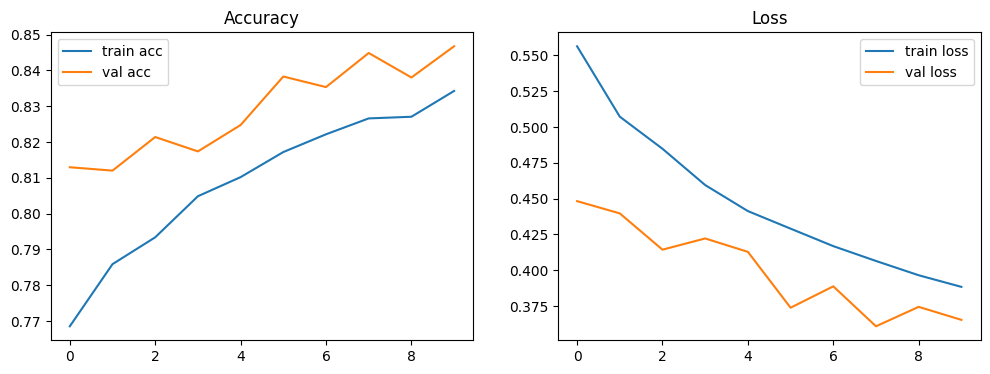

117/117 [==============================] - 21s 168ms/step - loss: 0.3726 - accuracy: 0.8417 - precision: 0.8519 - recall: 0.8308

✅ Test Accuracy: 0.842
✅ Test Precision: 0.852
✅ Test Recall: 0.831
1/1 [==============================] - 2s 2s/step


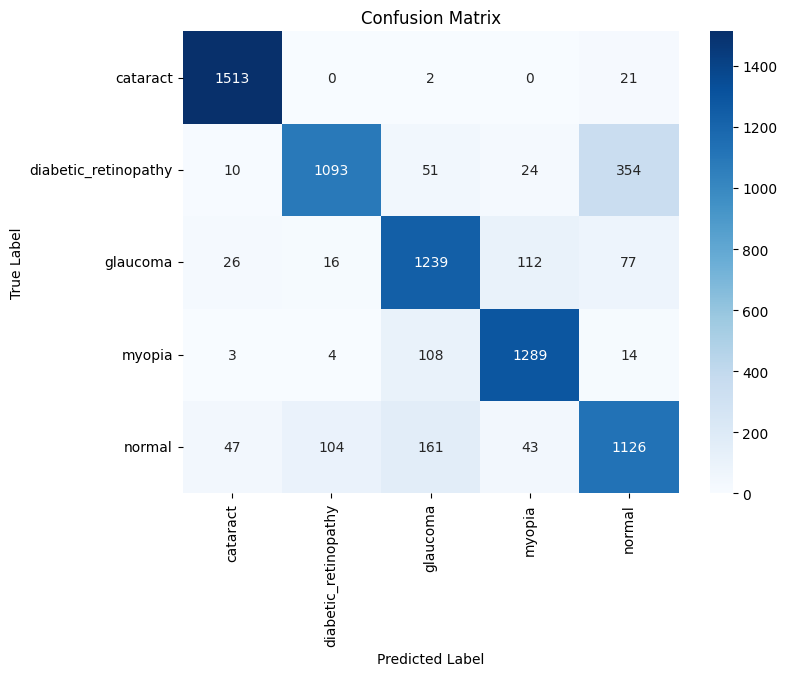


Classification Report:

                      precision    recall  f1-score   support

            cataract       0.95      0.99      0.97      1536
diabetic_retinopathy       0.90      0.71      0.80      1532
            glaucoma       0.79      0.84      0.82      1470
              myopia       0.88      0.91      0.89      1418
              normal       0.71      0.76      0.73      1481

            accuracy                           0.84      7437
           macro avg       0.84      0.84      0.84      7437
        weighted avg       0.85      0.84      0.84      7437



In [21]:

metrics = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=metrics
)


model.summary()



history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3)
    ]
)



plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss')
plt.show()

# ==========================================
# 🧪 EVALUATION ON TEST SET
# ==========================================
test_loss, test_acc, test_prec, test_rec = model.evaluate(test_ds)
print(f"\n✅ Test Accuracy: {test_acc:.3f}")
print(f"✅ Test Precision: {test_prec:.3f}")
print(f"✅ Test Recall: {test_rec:.3f}")

# ==========================================
# 🧩 CONFUSION MATRIX + REPORT
# ==========================================
y_true, y_pred = [], []
for x, y in test_ds:
    preds = model.predict(x)
    y_true.extend(tf.argmax(y, axis=1).numpy())
    y_pred.extend(tf.argmax(preds, axis=1).numpy())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


Epoch 1/15
542/542 [==============================] - 209s 367ms/step - loss: 1.7610 - accuracy: 0.6743 - precision: 0.6797 - recall: 0.6681 - val_loss: 1.0466 - val_accuracy: 0.7521 - val_precision: 0.7579 - val_recall: 0.7471 - lr: 3.0000e-05
Epoch 2/15
542/542 [==============================] - 194s 355ms/step - loss: 1.3183 - accuracy: 0.6963 - precision: 0.7038 - recall: 0.6891 - val_loss: 0.8534 - val_accuracy: 0.7660 - val_precision: 0.7737 - val_recall: 0.7588 - lr: 3.0000e-05
Epoch 3/15
542/542 [==============================] - 237s 434ms/step - loss: 1.0837 - accuracy: 0.7095 - precision: 0.7197 - recall: 0.6990 - val_loss: 0.7381 - val_accuracy: 0.7733 - val_precision: 0.7824 - val_recall: 0.7635 - lr: 3.0000e-05
Epoch 4/15
542/542 [==============================] - 193s 353ms/step - loss: 0.9458 - accuracy: 0.7195 - precision: 0.7322 - recall: 0.7053 - val_loss: 0.6686 - val_accuracy: 0.7790 - val_precision: 0.7893 - val_recall: 0.7668 - lr: 3.0000e-05
Epoch 5/15
542/542 [

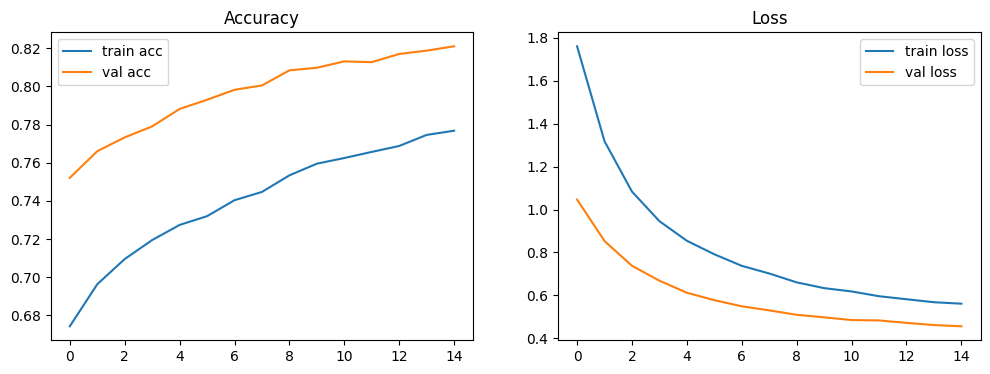

117/117 [==============================] - 20s 161ms/step - loss: 0.4795 - accuracy: 0.8084 - precision: 0.8269 - recall: 0.7832

✅ Test Accuracy: 0.808
✅ Test Precision: 0.827
✅ Test Recall: 0.783
1/1 [==============================] - 2s 2s/step


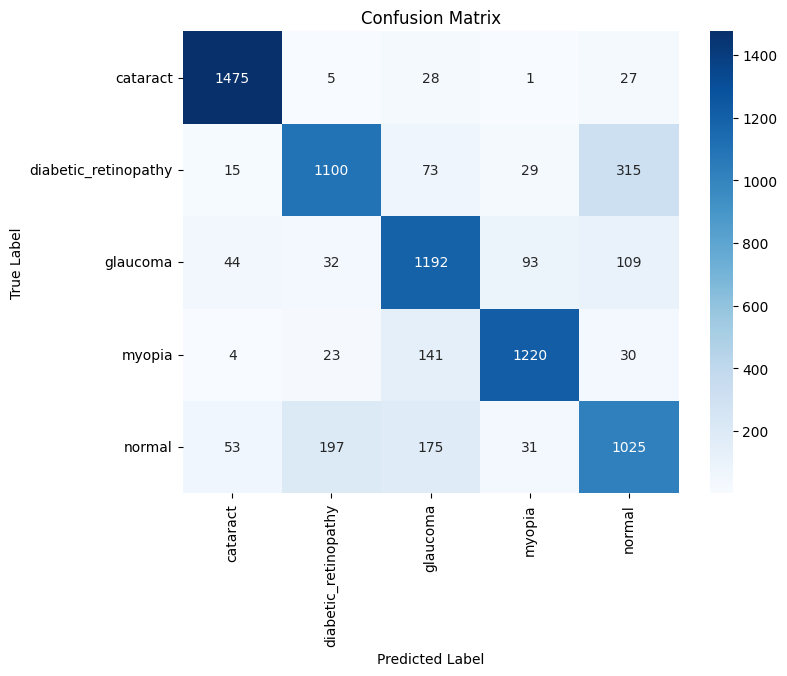


Classification Report:

                      precision    recall  f1-score   support

            cataract       0.93      0.96      0.94      1536
diabetic_retinopathy       0.81      0.72      0.76      1532
            glaucoma       0.74      0.81      0.77      1470
              myopia       0.89      0.86      0.87      1418
              normal       0.68      0.69      0.69      1481

            accuracy                           0.81      7437
           macro avg       0.81      0.81      0.81      7437
        weighted avg       0.81      0.81      0.81      7437



In [22]:
for layer in base.layers[-65:]:
    layer.trainable = True
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=3e-5),  # lower LR for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy', 'Precision', 'Recall']
)


history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    verbose=1,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2)
    ]
)



plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_finetune.history['accuracy'], label='train acc')
plt.plot(history_finetune.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history_finetune.history['loss'], label='train loss')
plt.plot(history_finetune.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss')
plt.show()

# ==========================================
# 🧪 EVALUATION ON TEST SET
# ==========================================
test_loss, test_acc, test_prec, test_rec = model.evaluate(test_ds)
print(f"\n✅ Test Accuracy: {test_acc:.3f}")
print(f"✅ Test Precision: {test_prec:.3f}")
print(f"✅ Test Recall: {test_rec:.3f}")

# ==========================================
# 🧩 CONFUSION MATRIX + REPORT
# ==========================================
y_true, y_pred = [], []
for x, y in test_ds:
    preds = model.predict(x)
    y_true.extend(tf.argmax(y, axis=1).numpy())
    y_pred.extend(tf.argmax(preds, axis=1).numpy())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


Epoch 1/15
542/542 [==============================] - 194s 355ms/step - loss: 0.5489 - accuracy: 0.7815 - precision: 0.8107 - recall: 0.7414 - val_loss: 0.4514 - val_accuracy: 0.8221 - val_precision: 0.8400 - val_recall: 0.7962 - lr: 3.0000e-05
Epoch 2/15
542/542 [==============================] - 226s 414ms/step - loss: 0.5393 - accuracy: 0.7834 - precision: 0.8159 - recall: 0.7434 - val_loss: 0.4473 - val_accuracy: 0.8226 - val_precision: 0.8431 - val_recall: 0.7975 - lr: 3.0000e-05
Epoch 3/15
542/542 [==============================] - 229s 421ms/step - loss: 0.5297 - accuracy: 0.7875 - precision: 0.8176 - recall: 0.7473 - val_loss: 0.4447 - val_accuracy: 0.8252 - val_precision: 0.8421 - val_recall: 0.7993 - lr: 3.0000e-05
Epoch 4/15
542/542 [==============================] - 194s 356ms/step - loss: 0.5284 - accuracy: 0.7882 - precision: 0.8192 - recall: 0.7473 - val_loss: 0.4386 - val_accuracy: 0.8274 - val_precision: 0.8449 - val_recall: 0.8018 - lr: 3.0000e-05
Epoch 5/15
542/542 [

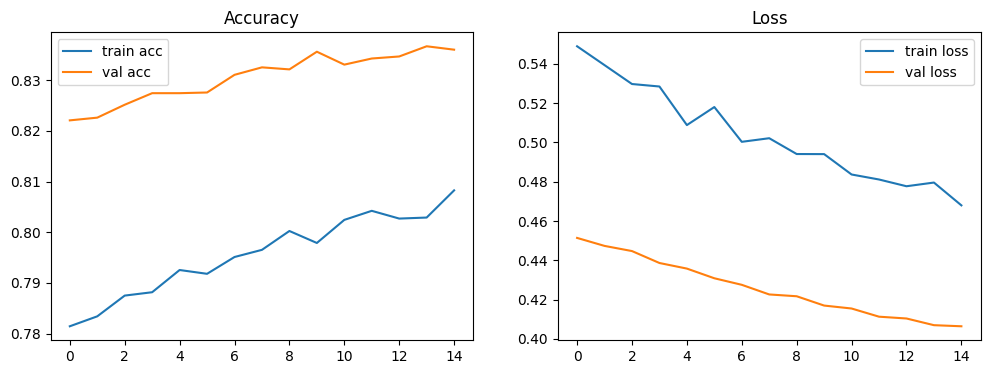

117/117 [==============================] - 23s 185ms/step - loss: 0.4244 - accuracy: 0.8245 - precision: 0.8428 - recall: 0.8038

✅ Test Accuracy: 0.825
✅ Test Precision: 0.843
✅ Test Recall: 0.804
1/1 [==============================] - 0s 25ms/step


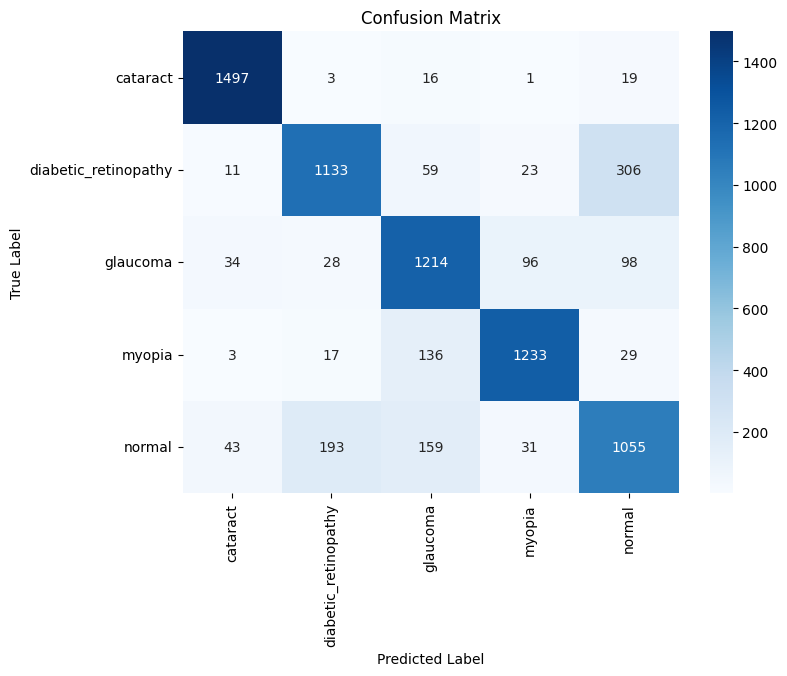


Classification Report:

                      precision    recall  f1-score   support

            cataract       0.94      0.97      0.96      1536
diabetic_retinopathy       0.82      0.74      0.78      1532
            glaucoma       0.77      0.83      0.80      1470
              myopia       0.89      0.87      0.88      1418
              normal       0.70      0.71      0.71      1481

            accuracy                           0.82      7437
           macro avg       0.82      0.82      0.82      7437
        weighted avg       0.83      0.82      0.82      7437



In [24]:


history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    verbose=1,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2)
    ]
)



plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_finetune.history['accuracy'], label='train acc')
plt.plot(history_finetune.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history_finetune.history['loss'], label='train loss')
plt.plot(history_finetune.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss')
plt.show()

# ==========================================
# 🧪 EVALUATION ON TEST SET
# ==========================================
test_loss, test_acc, test_prec, test_rec = model.evaluate(test_ds)
print(f"\n✅ Test Accuracy: {test_acc:.3f}")
print(f"✅ Test Precision: {test_prec:.3f}")
print(f"✅ Test Recall: {test_rec:.3f}")

# ==========================================
# 🧩 CONFUSION MATRIX + REPORT
# ==========================================
y_true, y_pred = [], []
for x, y in test_ds:
    preds = model.predict(x)
    y_true.extend(tf.argmax(y, axis=1).numpy())
    y_pred.extend(tf.argmax(preds, axis=1).numpy())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


In [25]:
# Save the entire model (architecture + weights + optimizer state)
model.save('my_finetuned_model.h5')  # or .keras extension
# OR
model.save('my_finetuned_model.keras')

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [26]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
import cv2


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Gradients of the predicted class w.r.t conv outputs
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize between 0 and 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


import random

# Pick random test image
class_names = test_ds.class_names
sample_images = list(test_ds.unbatch().take(10).as_numpy_iterator())

idx = random.randint(0, len(sample_images)-1)
img, label = sample_images[idx]
img_array = np.expand_dims(img, axis=0)

# Model prediction
preds = model.predict(img_array)
pred_class = np.argmax(preds[0])
true_class = np.argmax(label)

print(f"✅ True label: {class_names[true_class]}")
print(f"🔮 Predicted label: {class_names[pred_class]} (Confidence: {preds[0][pred_class]:.3f})")


# Choose last conv layer name (EfficientNetB3 specific)
last_conv_layer_name = [layer.name for layer in model.layers if 'top_conv' in layer.name][-1]

# Generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Rescale heatmap to match image size
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)

# Apply heatmap overlay
heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(cv2.cvtColor(np.uint8(img), cv2.COLOR_RGB2BGR), 0.6, heatmap_color, 0.4, 0)

# Plot
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img.astype("uint8"))
plt.title(f"Original - {class_names[true_class]}")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.title(f"Grad-CAM - {class_names[pred_class]}")
plt.axis("off")
plt.show()


1/1 [==============================] - 0s 24ms/step
✅ True label: myopia
🔮 Predicted label: glaucoma (Confidence: 0.525)


IndexError: list index out of range

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D
)
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.regularizers import l2

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D
)
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.regularizers import l2
# %%
AUTOTUNE = tf.data.AUTOTUNE

def prepare_train(ds):
    return ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y), num_parallel_calls=AUTOTUNE) \
             .cache() \
             .shuffle(1000) \
             .prefetch(buffer_size=AUTOTUNE)

def prepare_eval(ds):
    return ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y), num_parallel_calls=AUTOTUNE) \
             .cache() \
             .prefetch(buffer_size=AUTOTUNE)

train_ds = prepare_train(train_ds)
val_ds = prepare_eval(val_ds)
test_ds = prepare_eval(test_ds)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_9 (Bat  (None, 224, 224, 32)      128       
 chNormalization)                                                
                                                                 
 activation_9 (Activation)   (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 112, 112, 32)      0         
                                                                 
 conv2d_7 (Conv2D)           (None, 112, 112, 64)     

2025-10-29 06:48:13.769896: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:21: Filling up shuffle buffer (this may take a while): 94 of 1000
2025-10-29 06:48:23.949633: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:21: Filling up shuffle buffer (this may take a while): 157 of 1000
2025-10-29 06:48:43.895920: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:21: Filling up shuffle buffer (this may take a while): 282 of 1000
2025-10-29 06:49:03.755862: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:21: Filling up shuffle buffer (this may take a while): 419 of 1000
2025-10-29 06:49:13.812028: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:21: Filling up shuffle buffer (this may take a while): 484 of 1000
2025-10-29 06:49:22.611787: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


542/542 [==============================] - 244s 298ms/step - loss: 29.7558 - accuracy: 0.3538 - precision: 0.4379 - recall: 0.1986 - val_loss: 25.6538 - val_accuracy: 0.2080 - val_precision: 0.2080 - val_recall: 0.2080 - lr: 1.0000e-04
Epoch 2/50
542/542 [==============================] - 69s 127ms/step - loss: 19.0085 - accuracy: 0.4856 - precision: 0.6075 - recall: 0.3260 - val_loss: 16.1502 - val_accuracy: 0.2202 - val_precision: 0.2501 - val_recall: 0.2144 - lr: 1.0000e-04
Epoch 3/50
542/542 [==============================] - 69s 127ms/step - loss: 11.5754 - accuracy: 0.5532 - precision: 0.6625 - recall: 0.3946 - val_loss: 9.7028 - val_accuracy: 0.3355 - val_precision: 0.3804 - val_recall: 0.2826 - lr: 1.0000e-04
Epoch 4/50
542/542 [==============================] - 69s 127ms/step - loss: 7.0079 - accuracy: 0.6054 - precision: 0.7016 - recall: 0.4701 - val_loss: 6.4305 - val_accuracy: 0.3390 - val_precision: 0.4421 - val_recall: 0.2389 - lr: 1.0000e-04
Epoch 5/50
542/542 [=========

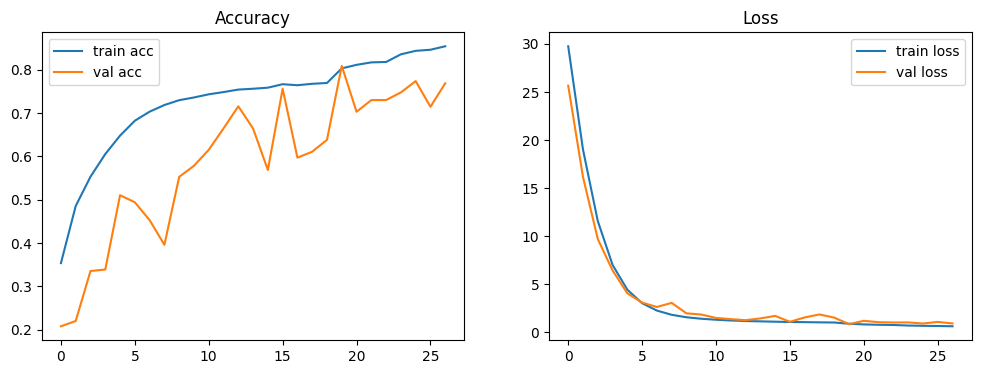

117/117 [==============================] - 20s 155ms/step - loss: 0.8464 - accuracy: 0.8040 - precision: 0.8227 - recall: 0.7824

✅ Test Accuracy: 0.804
✅ Test Precision: 0.823
✅ Test Recall: 0.782
1/1 [==============================] - 0s 158ms/step


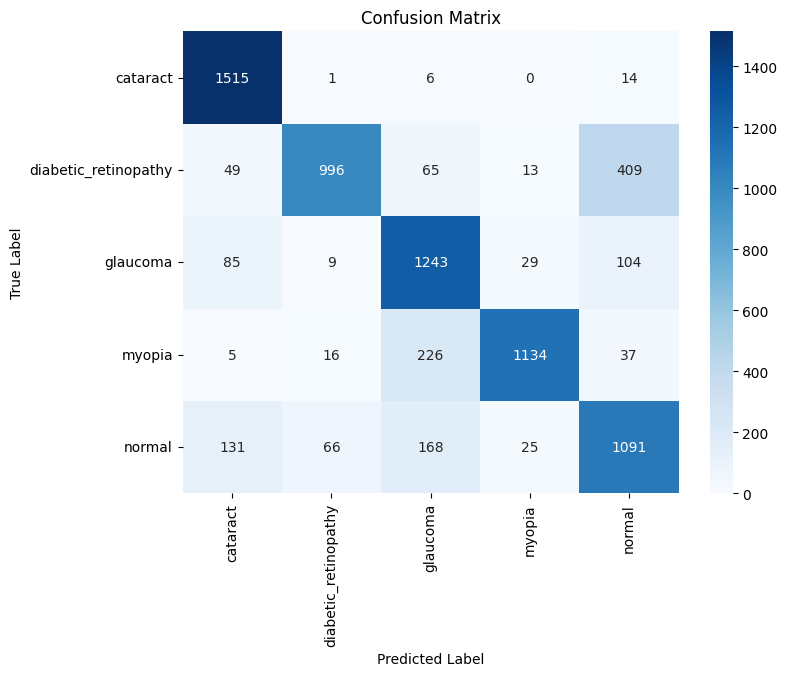


Classification Report:

                      precision    recall  f1-score   support

            cataract       0.85      0.99      0.91      1536
diabetic_retinopathy       0.92      0.65      0.76      1532
            glaucoma       0.73      0.85      0.78      1470
              myopia       0.94      0.80      0.87      1418
              normal       0.66      0.74      0.70      1481

            accuracy                           0.80      7437
           macro avg       0.82      0.80      0.80      7437
        weighted avg       0.82      0.80      0.80      7437



In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), padding='same', input_shape=(224, 224, 3), kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(512, (3, 3), padding='valid', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(1024, (3, 3), padding='valid', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    GlobalAveragePooling2D(),

    Dense(1024, kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),

    Dense(512, kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),

    Dense(256, kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),

    Dense(num_classes, activation='softmax')
])

metrics = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=metrics)

model.summary()



history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3)
    ]
)

# ==========================================
# 📈 PLOT ACCURACY & LOSS
# ==========================================
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss')
plt.show()

# ==========================================
# 🧪 EVALUATION ON TEST SET
# ==========================================
test_loss, test_acc, test_prec, test_rec = model.evaluate(test_ds)
print(f"\n✅ Test Accuracy: {test_acc:.3f}")
print(f"✅ Test Precision: {test_prec:.3f}")
print(f"✅ Test Recall: {test_rec:.3f}")

# ==========================================
# 🧩 CONFUSION MATRIX + REPORT
# ==========================================
y_true, y_pred = [], []
for x, y in test_ds:
    preds = model.predict(x)
    y_true.extend(tf.argmax(y, axis=1).numpy())
    y_pred.extend(tf.argmax(preds, axis=1).numpy())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


In [8]:


# ==========================================
# 📁 DATASET CONFIGURATION
# ==========================================
data_dir = "/storage/dataset_balanced"
img_size = (224, 224)
batch_size = 32
seed = 123

# ✅ Split into train+val (85%) and test (15%)
train_val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.15,
    subset="training",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.15,
    subset="validation",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

# ✅ Class info
class_names = train_val_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)

# ==========================================
# 🔀 Split train_val into train & val
# ==========================================
train_val_count = tf.data.experimental.cardinality(train_val_ds).numpy()
train_size = int(train_val_count * 0.8235)  # (70%/85%) = 0.8235

train_ds = train_val_ds.take(train_size)
val_ds = train_val_ds.skip(train_size)

Found 49583 files belonging to 5 classes.
Using 42146 files for training.
Found 49583 files belonging to 5 classes.
Using 7437 files for validation.
Classes: ['cataract', 'diabetic_retinopathy', 'glaucoma', 'myopia', 'normal']


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_18 (Ba  (None, 224, 224, 32)      128       
 tchNormalization)                                               
                                                                 
 activation_18 (Activation)  (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 112, 112, 32)      0         
 ng2D)                                                           
                                                                 
 dropout_18 (Dropout)        (None, 112, 112, 32)      0         
                                                                 
 conv2d_13 (Conv2D)          (None, 112, 112, 64)     

2025-10-29 08:06:05.418039: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_18/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1085/1085 [==============================] - 197s 172ms/step - loss: 27.4395 - accuracy: 0.3800 - precision: 0.4671 - recall: 0.2387 - val_loss: 19.8561 - val_accuracy: 0.3515 - val_precision: 0.7734 - val_recall: 0.0869 - lr: 1.0000e-04
Epoch 2/50
1085/1085 [==============================] - 232s 213ms/step - loss: 13.9983 - accuracy: 0.5067 - precision: 0.6153 - recall: 0.3555 - val_loss: 9.9622 - val_accuracy: 0.2614 - val_precision: 0.3752 - val_recall: 0.1130 - lr: 1.0000e-04
Epoch 3/50
1085/1085 [==============================] - 190s 174ms/step - loss: 6.7544 - accuracy: 0.5735 - precision: 0.6735 - recall: 0.4245 - val_loss: 5.2253 - val_accuracy: 0.3939 - val_precision: 0.5598 - val_recall: 0.2091 - lr: 1.0000e-04
Epoch 4/50
1085/1085 [==============================] - 196s 180ms/step - loss: 3.6260 - accuracy: 0.6380 - precision: 0.7135 - recall: 0.5180 - val_loss: 3.4531 - val_accuracy: 0.4009 - val_precision: 0.4698 - val_recall: 0.2766 - lr: 1.0000e-04
Epoch 5/50
1085/1085

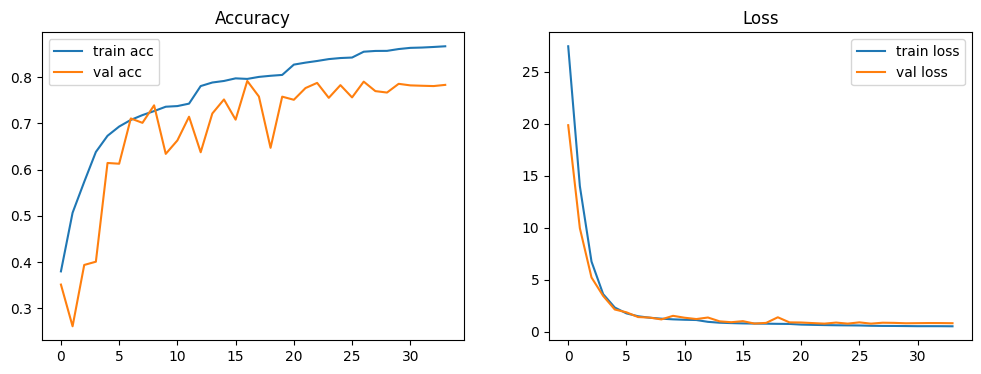

233/233 [==============================] - 19s 79ms/step - loss: 0.8028 - accuracy: 0.7776 - precision: 0.7896 - recall: 0.7642

✅ Test Accuracy: 0.778
✅ Test Precision: 0.790
✅ Test Recall: 0.764
1/1 [==============================] - 0s 172ms/step


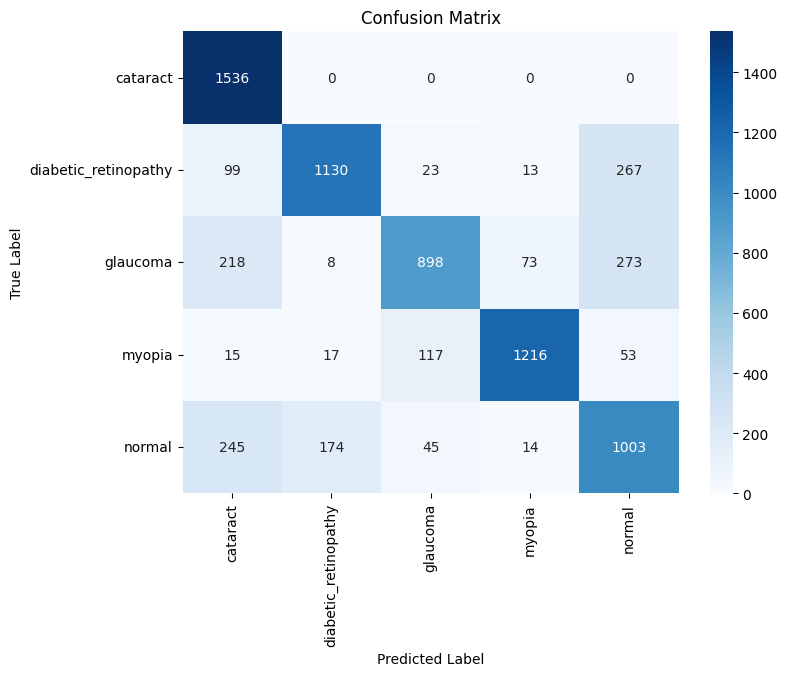


Classification Report:

                      precision    recall  f1-score   support

            cataract       0.73      1.00      0.84      1536
diabetic_retinopathy       0.85      0.74      0.79      1532
            glaucoma       0.83      0.61      0.70      1470
              myopia       0.92      0.86      0.89      1418
              normal       0.63      0.68      0.65      1481

            accuracy                           0.78      7437
           macro avg       0.79      0.78      0.78      7437
        weighted avg       0.79      0.78      0.78      7437



In [9]:
model = Sequential([
    Conv2D(32, (3, 3), padding='same', input_shape=(224, 224, 3), kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(512, (3, 3), padding='valid', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(1024, (3, 3), padding='valid', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    GlobalAveragePooling2D(),

    Dense(1024, kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),

    Dense(512, kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),

    Dense(256, kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),

    Dense(num_classes, activation='softmax')
])

metrics = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=metrics)

model.summary()



history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3)
    ]
)

# ==========================================
# 📈 PLOT ACCURACY & LOSS
# ==========================================
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss')
plt.show()

# ==========================================
# 🧪 EVALUATION ON TEST SET
# ==========================================
test_loss, test_acc, test_prec, test_rec = model.evaluate(test_ds)
print(f"\n✅ Test Accuracy: {test_acc:.3f}")
print(f"✅ Test Precision: {test_prec:.3f}")
print(f"✅ Test Recall: {test_rec:.3f}")

# ==========================================
# 🧩 CONFUSION MATRIX + REPORT
# ==========================================
y_true, y_pred = [], []
for x, y in test_ds:
    preds = model.predict(x)
    y_true.extend(tf.argmax(y, axis=1).numpy())
    y_pred.extend(tf.argmax(preds, axis=1).numpy())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D
)
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.regularizers import l2


2025-10-31 15:44:16.197745: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-31 15:44:16.197872: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-31 15:44:16.324100: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-31 15:44:16.558907: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-31 15:44:18.221886: W tensorflow/compiler/tf2

In [2]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:


# ==========================================
# 📁 DATASET CONFIGURATION
# ==========================================
data_dir = "/storage/dataset_balanced"
img_size = (224, 224)
batch_size = 64
seed = 123

# ✅ Split into train+val (85%) and test (15%)
train_val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.15,
    subset="training",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.15,
    subset="validation",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

# ✅ Class info
class_names = train_val_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)

# ==========================================
# 🔀 Split train_val into train & val
# ==========================================
train_val_count = tf.data.experimental.cardinality(train_val_ds).numpy()
train_size = int(train_val_count * 0.8235)  # (70%/85%) = 0.8235

train_ds = train_val_ds.take(train_size)
val_ds = train_val_ds.skip(train_size)

Found 49583 files belonging to 5 classes.
Using 42146 files for training.


2025-10-31 15:44:28.721240: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-10-31 15:44:29.196512: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-10-31 15:44:29.196788: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Found 49583 files belonging to 5 classes.
Using 7437 files for validation.
Classes: ['cataract', 'diabetic_retinopathy', 'glaucoma', 'myopia', 'normal']


In [9]:
from tensorflow.keras.applications.efficientnet import preprocess_input

def prepare_train(ds):
    return ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=AUTOTUNE) \
             .cache() \
             .shuffle(1000) \
             .prefetch(buffer_size=AUTOTUNE)

def prepare_eval(ds):
    return ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=AUTOTUNE) \
             .cache() \
             .prefetch(buffer_size=AUTOTUNE)


train_ds = prepare_train(train_ds)
val_ds = prepare_eval(val_ds)
test_ds = prepare_eval(test_ds)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 7, 7, 1536)        10783535  
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1536)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               786944    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 11573044 (44.15 MB)
Trainable params: 7895

2025-10-30 13:05:44.977296: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-10-30 13:05:46.628843: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f31d00ac250 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-30 13:05:46.628887: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capability 8.6
2025-10-30 13:05:46.655627: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1761829546.807437     558 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


542/542 [==============================] - 222s 390ms/step - loss: 0.6710 - accuracy: 0.7242 - precision: 0.7820 - recall: 0.6525 - val_loss: 0.5170 - val_accuracy: 0.7841 - val_precision: 0.8094 - val_recall: 0.7534 - lr: 0.0010
Epoch 2/12
542/542 [==============================] - 241s 442ms/step - loss: 0.5456 - accuracy: 0.7761 - precision: 0.8142 - recall: 0.7279 - val_loss: 0.4684 - val_accuracy: 0.8033 - val_precision: 0.8286 - val_recall: 0.7763 - lr: 0.0010
Epoch 3/12
542/542 [==============================] - 218s 399ms/step - loss: 0.5072 - accuracy: 0.7864 - precision: 0.8187 - recall: 0.7461 - val_loss: 0.4452 - val_accuracy: 0.8151 - val_precision: 0.8386 - val_recall: 0.7805 - lr: 0.0010
Epoch 4/12
542/542 [==============================] - 233s 428ms/step - loss: 0.4821 - accuracy: 0.7978 - precision: 0.8266 - recall: 0.7628 - val_loss: 0.4143 - val_accuracy: 0.8286 - val_precision: 0.8515 - val_recall: 0.7955 - lr: 0.0010
Epoch 5/12
542/542 [===========================

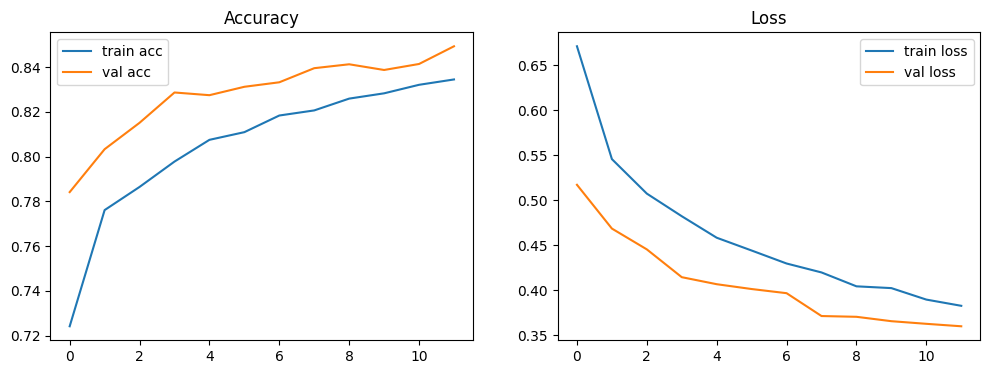

117/117 [==============================] - 24s 195ms/step - loss: 0.3667 - accuracy: 0.8482 - precision: 0.8633 - recall: 0.8290

✅ Test Accuracy: 0.848
✅ Test Precision: 0.863
✅ Test Recall: 0.829
1/1 [==============================] - 2s 2s/step


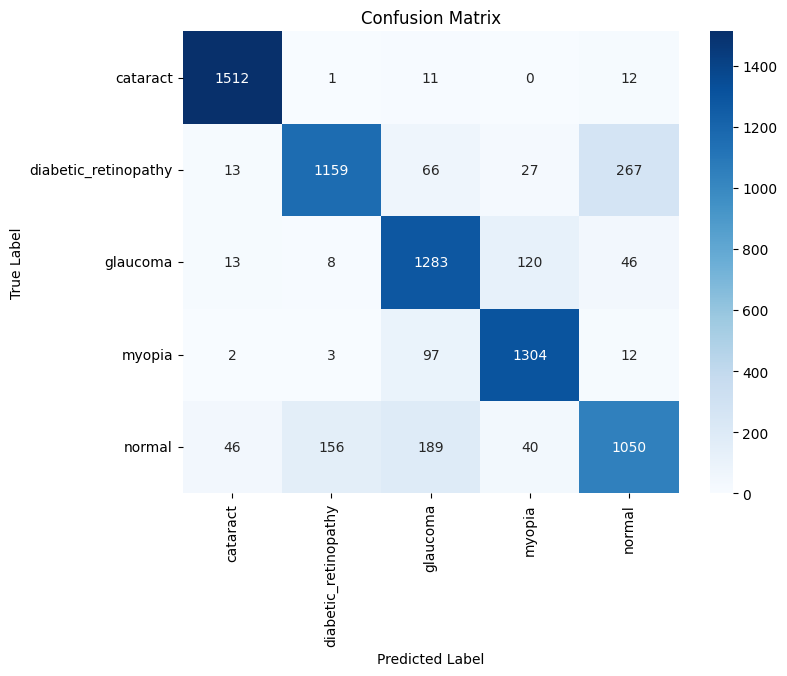


Classification Report:

                      precision    recall  f1-score   support

            cataract       0.95      0.98      0.97      1536
diabetic_retinopathy       0.87      0.76      0.81      1532
            glaucoma       0.78      0.87      0.82      1470
              myopia       0.87      0.92      0.90      1418
              normal       0.76      0.71      0.73      1481

            accuracy                           0.85      7437
           macro avg       0.85      0.85      0.85      7437
        weighted avg       0.85      0.85      0.85      7437



In [5]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

base = EfficientNetB3(include_top=False, weights='imagenet', input_shape=(224,224,3))
base.trainable = False

model = Sequential([
    base,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.4),
    Dense(5, activation='softmax')
])


metrics = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=metrics
)


model.summary()



history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=12,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2)
    ]
)



plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss')
plt.show()

# ==========================================
# 🧪 EVALUATION ON TEST SET
# ==========================================
test_loss, test_acc, test_prec, test_rec = model.evaluate(test_ds)
print(f"\n✅ Test Accuracy: {test_acc:.3f}")
print(f"✅ Test Precision: {test_prec:.3f}")
print(f"✅ Test Recall: {test_rec:.3f}")

# ==========================================
# 🧩 CONFUSION MATRIX + REPORT
# ==========================================
y_true, y_pred = [], []
for x, y in test_ds:
    preds = model.predict(x)
    y_true.extend(tf.argmax(y, axis=1).numpy())
    y_pred.extend(tf.argmax(preds, axis=1).numpy())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))



Epoch 1/25


2025-10-30 13:58:04.662751: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


542/542 [==============================] - 243s 427ms/step - loss: 0.7786 - accuracy: 0.7678 - precision: 0.7944 - recall: 0.7688 - val_loss: 0.4246 - val_accuracy: 0.8336 - val_precision: 0.8421 - val_recall: 0.8209 - lr: 3.0000e-05
Epoch 2/25
542/542 [==============================] - 248s 454ms/step - loss: 0.4433 - accuracy: 0.8156 - precision: 0.8355 - recall: 0.7945 - val_loss: 0.3711 - val_accuracy: 0.8479 - val_precision: 0.8582 - val_recall: 0.8352 - lr: 3.0000e-05
Epoch 3/25
542/542 [==============================] - 237s 434ms/step - loss: 0.3943 - accuracy: 0.8341 - precision: 0.8513 - recall: 0.8122 - val_loss: 0.3464 - val_accuracy: 0.8529 - val_precision: 0.8629 - val_recall: 0.8414 - lr: 3.0000e-05
Epoch 4/25
542/542 [==============================] - 211s 387ms/step - loss: 0.3630 - accuracy: 0.8452 - precision: 0.8593 - recall: 0.8270 - val_loss: 0.3321 - val_accuracy: 0.8604 - val_precision: 0.8688 - val_recall: 0.8505 - lr: 3.0000e-05
Epoch 5/25
542/542 [===========

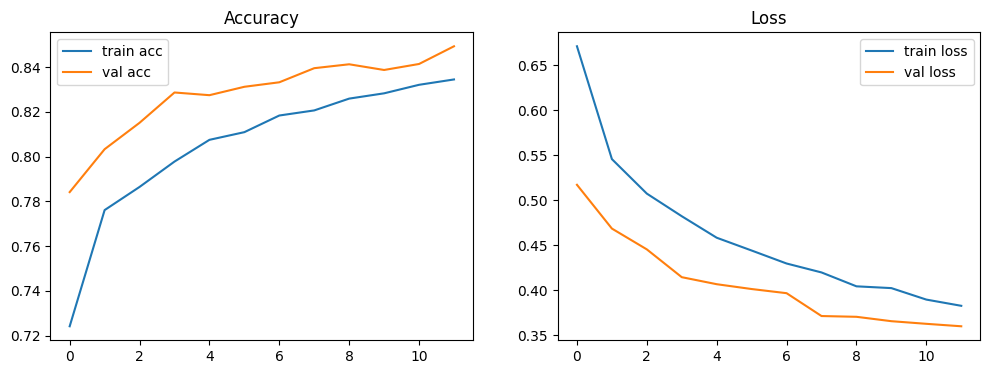

117/117 [==============================] - 22s 172ms/step - loss: 0.2819 - accuracy: 0.8846 - precision: 0.8870 - recall: 0.8834

✅ Test Accuracy: 0.885
✅ Test Precision: 0.887
✅ Test Recall: 0.883
1/1 [==============================] - 2s 2s/step


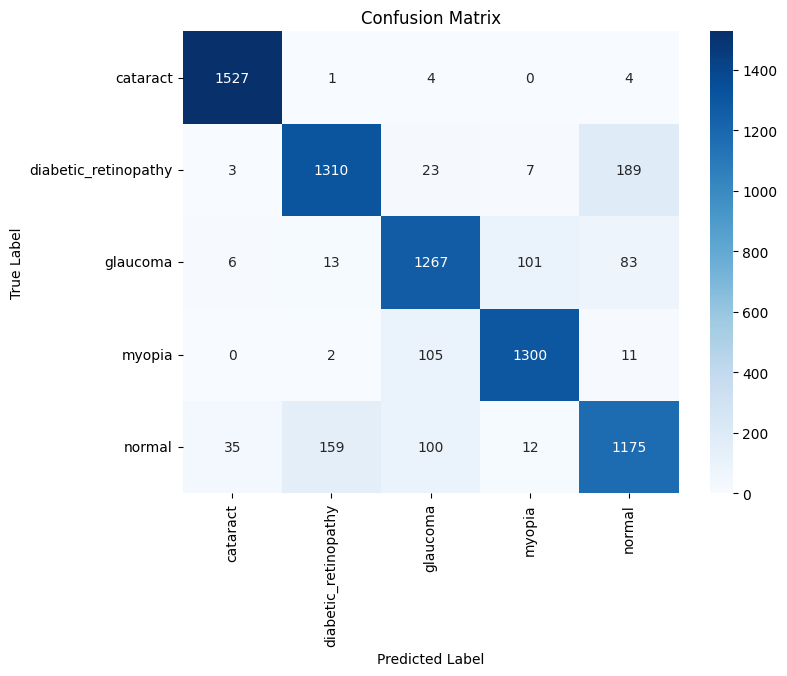


Classification Report:

                      precision    recall  f1-score   support

            cataract       0.97      0.99      0.98      1536
diabetic_retinopathy       0.88      0.86      0.87      1532
            glaucoma       0.85      0.86      0.85      1470
              myopia       0.92      0.92      0.92      1418
              normal       0.80      0.79      0.80      1481

            accuracy                           0.88      7437
           macro avg       0.88      0.88      0.88      7437
        weighted avg       0.88      0.88      0.88      7437



In [7]:
# Phase 1: already done (frozen base)

# Phase 2: fine-tune top layers
base.trainable = True
for layer in base.layers[:-30]:  # keep bottom layers frozen
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=3e-5),
    loss='categorical_crossentropy',
    metrics=metrics
)

history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2)
    ]
)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss')
plt.show()

# ==========================================
# 🧪 EVALUATION ON TEST SET
# ==========================================
test_loss, test_acc, test_prec, test_rec = model.evaluate(test_ds)
print(f"\n✅ Test Accuracy: {test_acc:.3f}")
print(f"✅ Test Precision: {test_prec:.3f}")
print(f"✅ Test Recall: {test_rec:.3f}")

# ==========================================
# 🧩 CONFUSION MATRIX + REPORT
# ==========================================
y_true, y_pred = [], []
for x, y in test_ds:
    preds = model.predict(x)
    y_true.extend(tf.argmax(y, axis=1).numpy())
    y_pred.extend(tf.argmax(preds, axis=1).numpy())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))




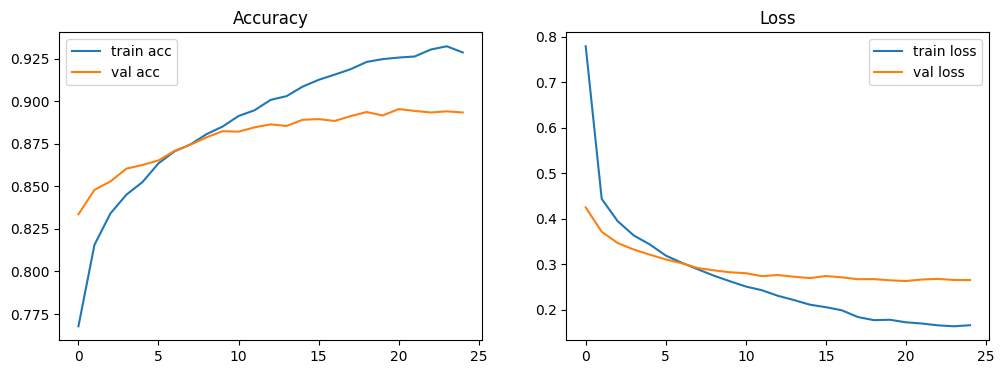

In [11]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_finetune.history['accuracy'], label='train acc')
plt.plot(history_finetune.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history_finetune.history['loss'], label='train loss')
plt.plot(history_finetune.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss')
plt.show()

In [8]:
model.save("/storage/efficientnetb3_finetuned.h5")

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [9]:
model.save("/storage/efficientnetb3_finetuned_90_val.keras")
model.save("/storage/efficientnetb3_finetuned_90_val.h5")


Epoch 1/25


2025-10-30 15:53:46.011436: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


542/542 [==============================] - 254s 440ms/step - loss: 0.2841 - accuracy: 0.8832 - precision: 0.8889 - recall: 0.8771 - val_loss: 0.2986 - val_accuracy: 0.8753 - val_precision: 0.8792 - val_recall: 0.8717 - lr: 1.0000e-05
Epoch 2/25
542/542 [==============================] - 252s 463ms/step - loss: 0.2474 - accuracy: 0.8948 - precision: 0.9013 - recall: 0.8877 - val_loss: 0.2867 - val_accuracy: 0.8832 - val_precision: 0.8860 - val_recall: 0.8803 - lr: 1.0000e-05
Epoch 3/25
542/542 [==============================] - 228s 418ms/step - loss: 0.2249 - accuracy: 0.9045 - precision: 0.9096 - recall: 0.8984 - val_loss: 0.2768 - val_accuracy: 0.8844 - val_precision: 0.8874 - val_recall: 0.8817 - lr: 1.0000e-05
Epoch 4/25
542/542 [==============================] - 229s 420ms/step - loss: 0.2098 - accuracy: 0.9106 - precision: 0.9151 - recall: 0.9051 - val_loss: 0.2769 - val_accuracy: 0.8854 - val_precision: 0.8879 - val_recall: 0.8833 - lr: 1.0000e-05
Epoch 5/25
542/542 [===========

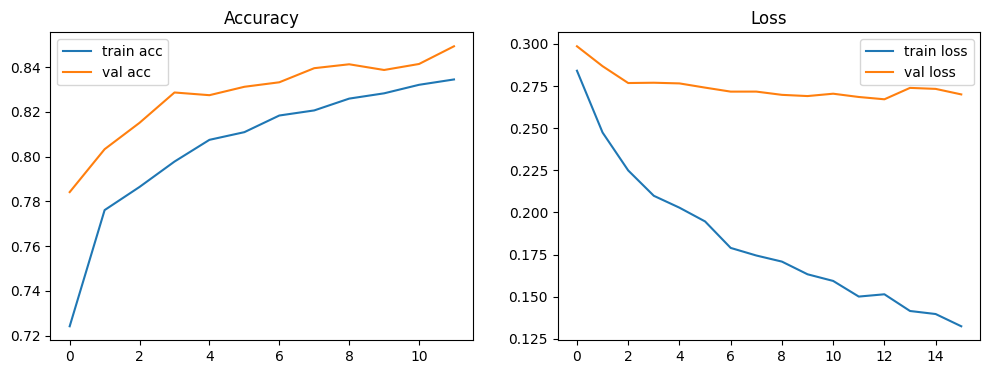

In [12]:
# Phase 1: already done (frozen base)

# Phase 2: fine-tune more layers
base.trainable = True
for layer in base.layers[:-80]:  # keep bottom layers frozen
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=metrics
)

history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2)
    ]
)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history_finetune.history['loss'], label='train loss')
plt.plot(history_finetune.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss')
plt.show()


In [5]:
from tensorflow.keras.models import load_model

model = load_model("/storage/efficientnetb3_finetuned_90_val.keras")


In [6]:
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)


0 efficientnetb3 True
1 global_average_pooling2d True
2 dense True
3 dropout True
4 dense_1 True


In [7]:
test_loss, test_acc, test_precision, test_recall = model.evaluate(test_ds, verbose=1)

print(f"📊 Test Loss: {test_loss:.4f}")
print(f"✅ Test Accuracy: {test_acc:.4f}")
print(f"🎯 Test Precision: {test_precision:.4f}")
print(f"📈 Test Recall: {test_recall:.4f}")


2025-10-31 11:33:50.652477: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907


117/117 [==============================] - 23s 145ms/step - loss: 0.2819 - accuracy: 0.8846 - precision: 0.8870 - recall: 0.8834
📊 Test Loss: 0.2819
✅ Test Accuracy: 0.8846
🎯 Test Precision: 0.8870
📈 Test Recall: 0.8834


In [8]:
base_model = model.get_layer("efficientnetb3")

for layer in base_model.layers[:-80]:  # keep bottom layers frozen
    layer.trainable = False

for layer in base_model.layers[-80:]:
    layer.trainable = True

In [9]:
from tensorflow.keras.optimizers import AdamW

In [6]:

metrics = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

Epoch 1/25


2025-10-31 11:41:12.820728: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-10-31 11:41:16.597689: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f7004a46830 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-31 11:41:16.597746: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capability 8.6
2025-10-31 11:41:16.615079: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1761910876.732391     103 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


542/542 [==============================] - 207s 348ms/step - loss: 0.2962 - accuracy: 0.8783 - precision: 0.8851 - recall: 0.8711 - val_loss: 0.3120 - val_accuracy: 0.8715 - val_precision: 0.8765 - val_recall: 0.8686 - lr: 5.0000e-06
Epoch 2/25
542/542 [==============================] - 233s 427ms/step - loss: 0.2611 - accuracy: 0.8892 - precision: 0.8959 - recall: 0.8820 - val_loss: 0.2999 - val_accuracy: 0.8772 - val_precision: 0.8810 - val_recall: 0.8728 - lr: 5.0000e-06
Epoch 3/25
542/542 [==============================] - 190s 349ms/step - loss: 0.2466 - accuracy: 0.8974 - precision: 0.9039 - recall: 0.8905 - val_loss: 0.2925 - val_accuracy: 0.8797 - val_precision: 0.8832 - val_recall: 0.8762 - lr: 5.0000e-06
Epoch 4/25
542/542 [==============================] - 189s 346ms/step - loss: 0.2320 - accuracy: 0.9017 - precision: 0.9075 - recall: 0.8944 - val_loss: 0.2859 - val_accuracy: 0.8823 - val_precision: 0.8853 - val_recall: 0.8791 - lr: 5.0000e-06
Epoch 5/25
542/542 [===========

NameError: name 'history' is not defined

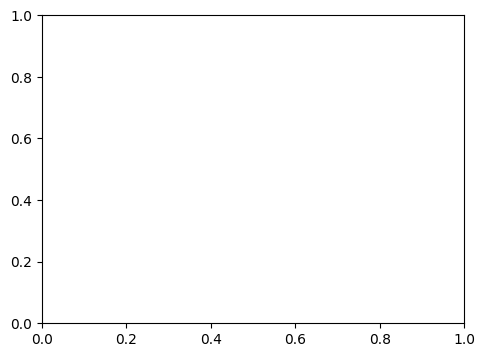

In [ ]:
model.compile(
    optimizer=AdamW(learning_rate=5e-6, weight_decay=1e-6),
    loss='categorical_crossentropy',
    metrics=metrics
)

history_finetune2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2)
    ]
)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_finetune2.history['accuracy'], label='train acc')
plt.plot(history_finetune2.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history_finetune.history['loss'], label='train loss')
plt.plot(history_finetune.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss')
plt.show()


# ==========================================
# 🧪 EVALUATION ON TEST SET
# ==========================================
test_loss, test_acc, test_prec, test_rec = model.evaluate(test_ds)
print(f"\n✅ Test Accuracy: {test_acc:.3f}")
print(f"✅ Test Precision: {test_prec:.3f}")
print(f"✅ Test Recall: {test_rec:.3f}")

# ==========================================
# 🧩 CONFUSION MATRIX + REPORT
# ==========================================
y_true, y_pred = [], []
for x, y in test_ds:
    preds = model.predict(x)
    y_true.extend(tf.argmax(y, axis=1).numpy())
    y_pred.extend(tf.argmax(preds, axis=1).numpy())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))





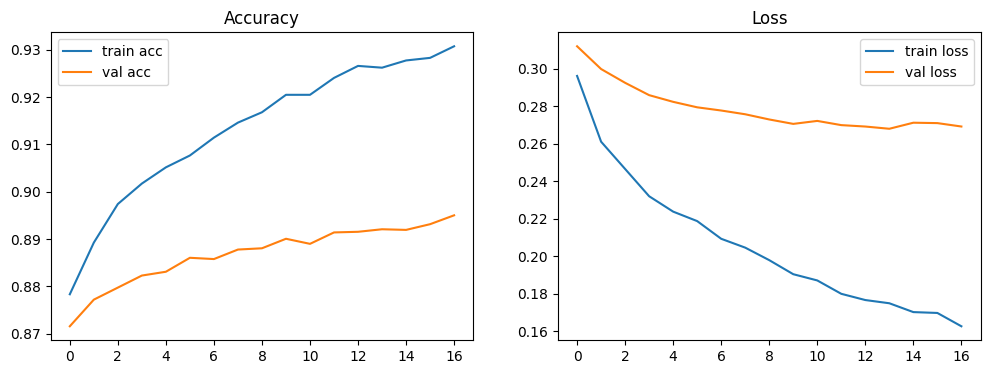

117/117 [==============================] - 20s 156ms/step - loss: 0.2906 - accuracy: 0.8823 - precision: 0.8851 - recall: 0.8806

✅ Test Accuracy: 0.882
✅ Test Precision: 0.885
✅ Test Recall: 0.881
1/1 [==============================] - 2s 2s/step


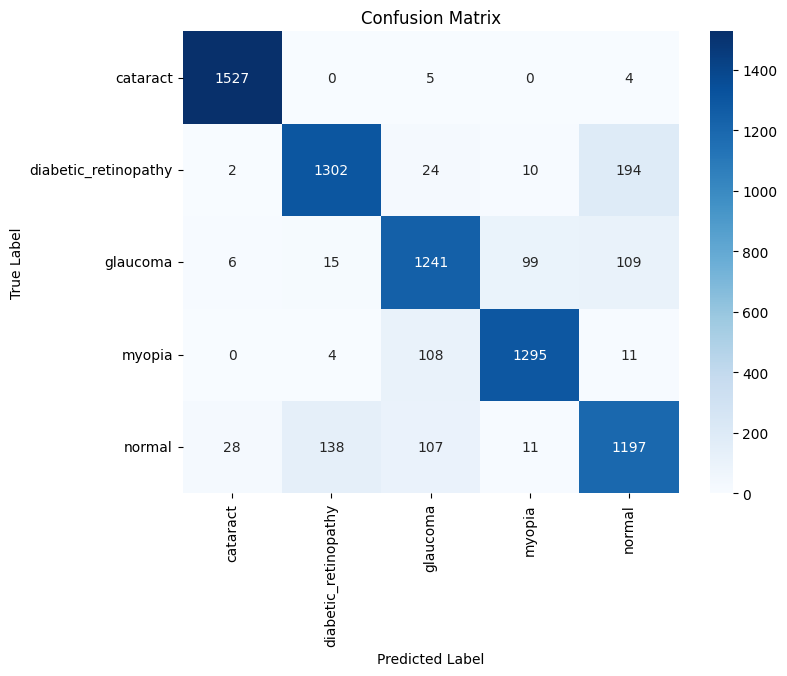


Classification Report:

                      precision    recall  f1-score   support

            cataract       0.98      0.99      0.99      1536
diabetic_retinopathy       0.89      0.85      0.87      1532
            glaucoma       0.84      0.84      0.84      1470
              myopia       0.92      0.91      0.91      1418
              normal       0.79      0.81      0.80      1481

            accuracy                           0.88      7437
           macro avg       0.88      0.88      0.88      7437
        weighted avg       0.88      0.88      0.88      7437



In [14]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_finetune2.history['accuracy'], label='train acc')
plt.plot(history_finetune2.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history_finetune2.history['loss'], label='train loss')
plt.plot(history_finetune2.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss')
plt.show()


# ==========================================
# 🧪 EVALUATION ON TEST SET
# ==========================================
test_loss, test_acc, test_prec, test_rec = model.evaluate(test_ds)
print(f"\n✅ Test Accuracy: {test_acc:.3f}")
print(f"✅ Test Precision: {test_prec:.3f}")
print(f"✅ Test Recall: {test_rec:.3f}")

# ==========================================
# 🧩 CONFUSION MATRIX + REPORT
# ==========================================
y_true, y_pred = [], []
for x, y in test_ds:
    preds = model.predict(x)
    y_true.extend(tf.argmax(y, axis=1).numpy())
    y_pred.extend(tf.argmax(preds, axis=1).numpy())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))





In [15]:
model = load_model("/storage/efficientnetb3_finetuned_90_val.keras")

base_model = model.get_layer("efficientnetb3")

for layer in base_model.layers[:-80]:  # keep bottom layers frozen
    layer.trainable = False

for layer in base_model.layers[-80:]:
    layer.trainable = True

In [16]:
model.compile(
    optimizer=AdamW(learning_rate=6e-7, weight_decay=1e-5),
    loss='categorical_crossentropy',
    metrics=metrics
)

history_finetune3 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2)
    ]
)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_finetune3.history['accuracy'], label='train acc')
plt.plot(history_finetune3.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history_finetune3.history['loss'], label='train loss')
plt.plot(history_finetune3.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss')
plt.show()


# ==========================================
# 🧪 EVALUATION ON TEST SET
# ==========================================
test_loss, test_acc, test_prec, test_rec = model.evaluate(test_ds)
print(f"\n✅ Test Accuracy: {test_acc:.3f}")
print(f"✅ Test Precision: {test_prec:.3f}")
print(f"✅ Test Recall: {test_rec:.3f}")

# ==========================================
# 🧩 CONFUSION MATRIX + REPORT
# ==========================================
y_true, y_pred = [], []
for x, y in test_ds:
    preds = model.predict(x)
    y_true.extend(tf.argmax(y, axis=1).numpy())
    y_pred.extend(tf.argmax(preds, axis=1).numpy())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))





Epoch 1/25


2025-10-31 13:15:27.399477: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


542/542 [==============================] - 208s 353ms/step - loss: 0.3219 - accuracy: 0.8719 - precision: 0.8799 - recall: 0.8681 - val_loss: 0.3479 - val_accuracy: 0.8634 - val_precision: 0.8673 - val_recall: 0.8606 - lr: 6.0000e-07
Epoch 2/25
542/542 [==============================] - 195s 357ms/step - loss: 0.3045 - accuracy: 0.8771 - precision: 0.8835 - recall: 0.8702 - val_loss: 0.3391 - val_accuracy: 0.8659 - val_precision: 0.8692 - val_recall: 0.8627 - lr: 6.0000e-07
Epoch 3/25
542/542 [==============================] - 193s 352ms/step - loss: 0.2975 - accuracy: 0.8766 - precision: 0.8837 - recall: 0.8698 - val_loss: 0.3333 - val_accuracy: 0.8679 - val_precision: 0.8712 - val_recall: 0.8651 - lr: 6.0000e-07
Epoch 4/25
542/542 [==============================] - 196s 360ms/step - loss: 0.2894 - accuracy: 0.8815 - precision: 0.8881 - recall: 0.8753 - val_loss: 0.3274 - val_accuracy: 0.8687 - val_precision: 0.8715 - val_recall: 0.8655 - lr: 6.0000e-07
Epoch 5/25
542/542 [===========

KeyboardInterrupt: 

In [19]:
%pip install -q tensorflow-hub


Note: you may need to restart the kernel to use updated packages.


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Number of disease classes
num_classes = 5  # adjust if needed

# Load Vision Transformer B16 (pretrained on ImageNet-21k)
MODEL_URL = "https://tfhub.dev/sayakpaul/vit_b16_fe/1"

# Load ViT feature extractor
base_model = hub.KerasLayer(MODEL_URL, trainable=False, input_shape=(224, 224, 3))

# Build the full model
model = models.Sequential([
    base_model,
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(num_classes, activation='softmax')
])

# Compile
metrics = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss='categorical_crossentropy',
    metrics=metrics
)

model.summary()

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3)
    ]
)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 768)               85798656  
                                                                 
 dense (Dense)               (None, 512)               393728    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 86194949 (328.81 MB)
Trainable params: 396293 (1.51 MB)
Non-trainable params: 85798656 (327.30 MB)
_________________________________________________________________
Epoch 1/20
542/542 [==============================] - 215s 380ms/step - loss: 1.1231 - accuracy: 0.5323 - precision: 0.6659 - recall: 0.3464 


KeyboardInterrupt



In [5]:
from tensorflow.keras.models import load_model

model = load_model("/storage/efficientnetb3_finetuned_90_val.keras")

base_model = model.get_layer("efficientnetb3")

for layer in base_model.layers[:-80]:  # keep bottom layers frozen
    layer.trainable = False

for layer in base_model.layers[-80:]:
    layer.trainable = True

Epoch 1/25


2025-10-31 15:48:33.170929: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-10-31 15:48:36.231561: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-10-31 15:48:38.545465: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fc840dacf20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-31 15:48:38.545509: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capability 8.6
2025-10-31 15:48:38.594741: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1761925718.774521     101 device_compiler.h:186] Compiled clu

542/542 [==============================] - 220s 370ms/step - loss: 0.3063 - accuracy: 0.8764 - precision: 0.8822 - recall: 0.8693 - val_loss: 0.3210 - val_accuracy: 0.8701 - val_precision: 0.8733 - val_recall: 0.8673 - lr: 3.0000e-06
Epoch 2/25
542/542 [==============================] - 196s 359ms/step - loss: 0.2772 - accuracy: 0.8858 - precision: 0.8921 - recall: 0.8782 - val_loss: 0.3106 - val_accuracy: 0.8737 - val_precision: 0.8774 - val_recall: 0.8706 - lr: 3.0000e-06
Epoch 3/25
542/542 [==============================] - 201s 368ms/step - loss: 0.2639 - accuracy: 0.8898 - precision: 0.8966 - recall: 0.8830 - val_loss: 0.2996 - val_accuracy: 0.8777 - val_precision: 0.8818 - val_recall: 0.8741 - lr: 3.0000e-06
Epoch 4/25
542/542 [==============================] - 197s 360ms/step - loss: 0.2505 - accuracy: 0.8940 - precision: 0.9021 - recall: 0.8862 - val_loss: 0.2945 - val_accuracy: 0.8784 - val_precision: 0.8828 - val_recall: 0.8757 - lr: 3.0000e-06
Epoch 5/25
542/542 [===========

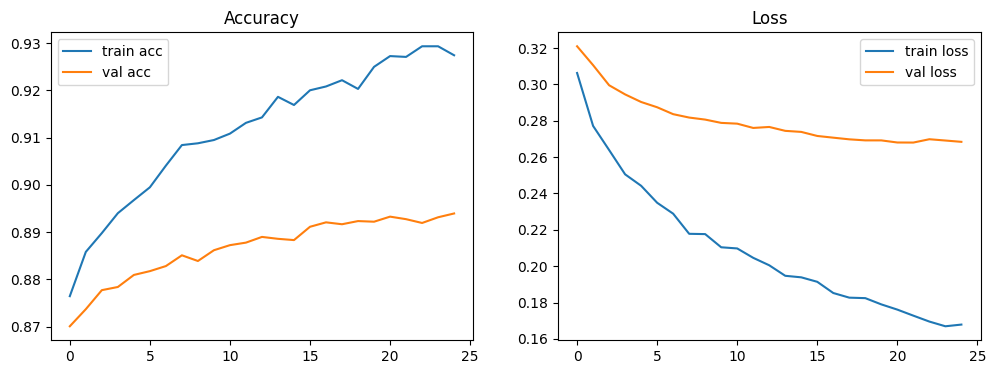

117/117 [==============================] - 21s 169ms/step - loss: 0.2888 - accuracy: 0.8833 - precision: 0.8861 - recall: 0.8819

✅ Test Accuracy: 0.883
✅ Test Precision: 0.886
✅ Test Recall: 0.882
1/1 [==============================] - 2s 2s/step


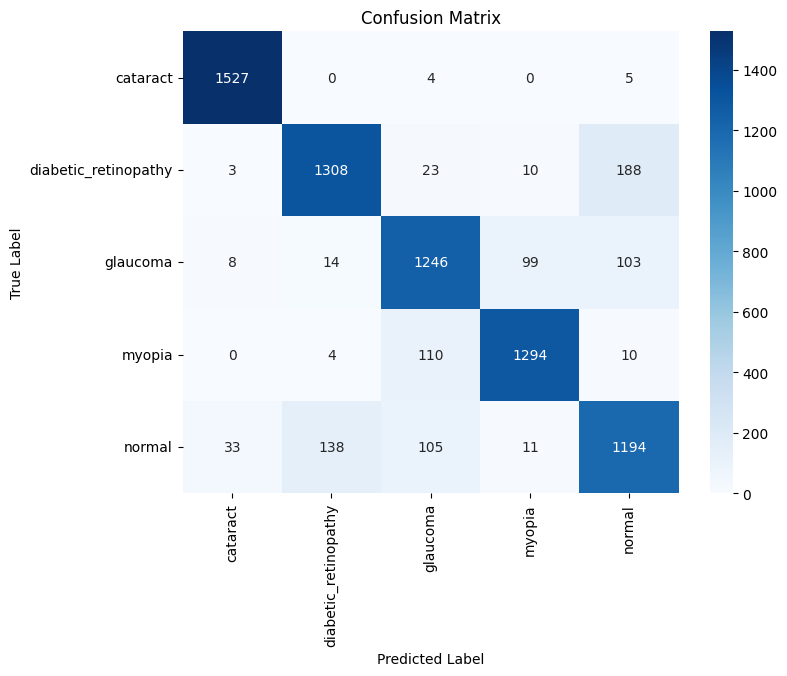


Classification Report:

                      precision    recall  f1-score   support

            cataract       0.97      0.99      0.98      1536
diabetic_retinopathy       0.89      0.85      0.87      1532
            glaucoma       0.84      0.85      0.84      1470
              myopia       0.92      0.91      0.91      1418
              normal       0.80      0.81      0.80      1481

            accuracy                           0.88      7437
           macro avg       0.88      0.88      0.88      7437
        weighted avg       0.88      0.88      0.88      7437



In [7]:
model.compile(
    optimizer=Adam(learning_rate=3e-6),
    loss='categorical_crossentropy',
    metrics=metrics
)

history_finetune3 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2)
    ]
)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_finetune3.history['accuracy'], label='train acc')
plt.plot(history_finetune3.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history_finetune3.history['loss'], label='train loss')
plt.plot(history_finetune3.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss')
plt.show()


# ==========================================
# 🧪 EVALUATION ON TEST SET
# ==========================================
test_loss, test_acc, test_prec, test_rec = model.evaluate(test_ds)
print(f"\n✅ Test Accuracy: {test_acc:.3f}")
print(f"✅ Test Precision: {test_prec:.3f}")
print(f"✅ Test Recall: {test_rec:.3f}")

# ==========================================
# 🧩 CONFUSION MATRIX + REPORT
# ==========================================
y_true, y_pred = [], []
for x, y in test_ds:
    preds = model.predict(x)
    y_true.extend(tf.argmax(y, axis=1).numpy())
    y_pred.extend(tf.argmax(preds, axis=1).numpy())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))





In [8]:
from tensorflow.keras.models import load_model

model = load_model("/storage/efficientnetb3_finetuned_90_val.keras")

base_model = model.get_layer("efficientnetb3")

# Freeze all layers except the last 120
for layer in base_model.layers[:-120]:
    layer.trainable = False

for layer in base_model.layers[-120:]:
    layer.trainable = True

Epoch 1/25


2025-10-31 17:23:07.918191: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


542/542 [==============================] - 225s 374ms/step - loss: 0.4675 - accuracy: 0.8206 - precision: 0.8429 - recall: 0.8212 - val_loss: 0.3786 - val_accuracy: 0.8502 - val_precision: 0.8570 - val_recall: 0.8427 - lr: 7.0000e-06
Epoch 2/25
542/542 [==============================] - 243s 445ms/step - loss: 0.3612 - accuracy: 0.8486 - precision: 0.8607 - recall: 0.8361 - val_loss: 0.3395 - val_accuracy: 0.8608 - val_precision: 0.8669 - val_recall: 0.8516 - lr: 7.0000e-06
Epoch 3/25
542/542 [==============================] - 202s 371ms/step - loss: 0.3205 - accuracy: 0.8651 - precision: 0.8753 - recall: 0.8538 - val_loss: 0.3202 - val_accuracy: 0.8666 - val_precision: 0.8722 - val_recall: 0.8606 - lr: 7.0000e-06
Epoch 4/25
542/542 [==============================] - 207s 378ms/step - loss: 0.2921 - accuracy: 0.8766 - precision: 0.8847 - recall: 0.8667 - val_loss: 0.3080 - val_accuracy: 0.8695 - val_precision: 0.8752 - val_recall: 0.8650 - lr: 7.0000e-06
Epoch 5/25
542/542 [===========

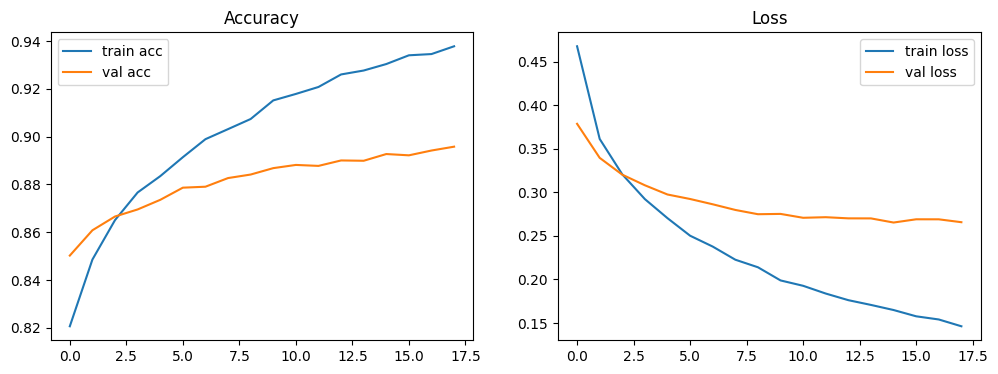

117/117 [==============================] - 20s 162ms/step - loss: 0.2789 - accuracy: 0.8852 - precision: 0.8878 - recall: 0.8833

✅ Test Accuracy: 0.885
✅ Test Precision: 0.888
✅ Test Recall: 0.883
1/1 [==============================] - 2s 2s/step


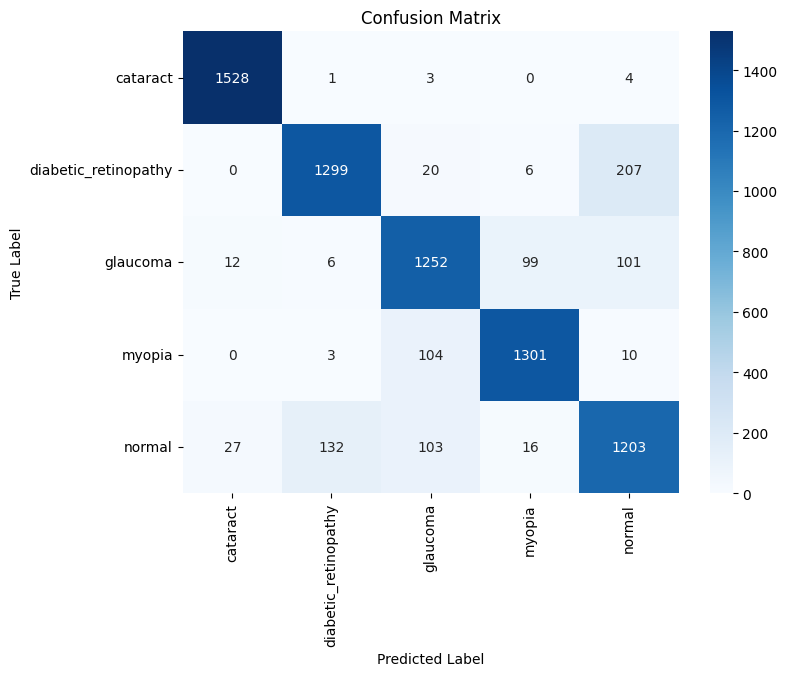


Classification Report:

                      precision    recall  f1-score   support

            cataract       0.98      0.99      0.98      1536
diabetic_retinopathy       0.90      0.85      0.87      1532
            glaucoma       0.84      0.85      0.85      1470
              myopia       0.91      0.92      0.92      1418
              normal       0.79      0.81      0.80      1481

            accuracy                           0.89      7437
           macro avg       0.89      0.88      0.88      7437
        weighted avg       0.89      0.89      0.89      7437



In [ ]:
from tensorflow.keras.models import load_model

model = load_model("/storage/efficientnetb3_finetuned_90_val.keras")

base_model = model.get_layer("efficientnetb3")

# Freeze all layers except the last 120
for layer in base_model.layers[:-120]:
    layer.trainable = False

for layer in base_model.layers[-120:]:
    layer.trainable = True
    
model.compile(
    optimizer=Adam(learning_rate=7e-6),
    loss='categorical_crossentropy',
    metrics=metrics
)

history_finetune4 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2)
    ]
)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_finetune4.history['accuracy'], label='train acc')
plt.plot(history_finetune4.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history_finetune4.history['loss'], label='train loss')
plt.plot(history_finetune4.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss')
plt.show()


# ==========================================
# 🧪 EVALUATION ON TEST SET
# ==========================================
test_loss, test_acc, test_prec, test_rec = model.evaluate(test_ds)
print(f"\n✅ Test Accuracy: {test_acc:.3f}")
print(f"✅ Test Precision: {test_prec:.3f}")
print(f"✅ Test Recall: {test_rec:.3f}")

# ==========================================
# 🧩 CONFUSION MATRIX + REPORT
# ==========================================
y_true, y_pred = [], []
for x, y in test_ds:
    preds = model.predict(x)
    y_true.extend(tf.argmax(y, axis=1).numpy())
    y_pred.extend(tf.argmax(preds, axis=1).numpy())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))





Epoch 1/25


2025-10-31 18:44:35.636095: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


542/542 [==============================] - 257s 429ms/step - loss: 0.2926 - accuracy: 0.8838 - precision: 0.8892 - recall: 0.8785 - val_loss: 0.3277 - val_accuracy: 0.8694 - val_precision: 0.8724 - val_recall: 0.8662 - lr: 7.0000e-08
Epoch 2/25
542/542 [==============================] - 231s 423ms/step - loss: 0.2952 - accuracy: 0.8817 - precision: 0.8878 - recall: 0.8757 - val_loss: 0.3279 - val_accuracy: 0.8683 - val_precision: 0.8727 - val_recall: 0.8656 - lr: 7.0000e-08
Epoch 3/25
542/542 [==============================] - 227s 417ms/step - loss: 0.2912 - accuracy: 0.8828 - precision: 0.8886 - recall: 0.8765 - val_loss: 0.3263 - val_accuracy: 0.8683 - val_precision: 0.8720 - val_recall: 0.8650 - lr: 7.0000e-08
Epoch 4/25
542/542 [==============================] - 230s 422ms/step - loss: 0.2863 - accuracy: 0.8844 - precision: 0.8903 - recall: 0.8783 - val_loss: 0.3212 - val_accuracy: 0.8702 - val_precision: 0.8741 - val_recall: 0.8675 - lr: 7.0000e-08
Epoch 5/25
542/542 [===========

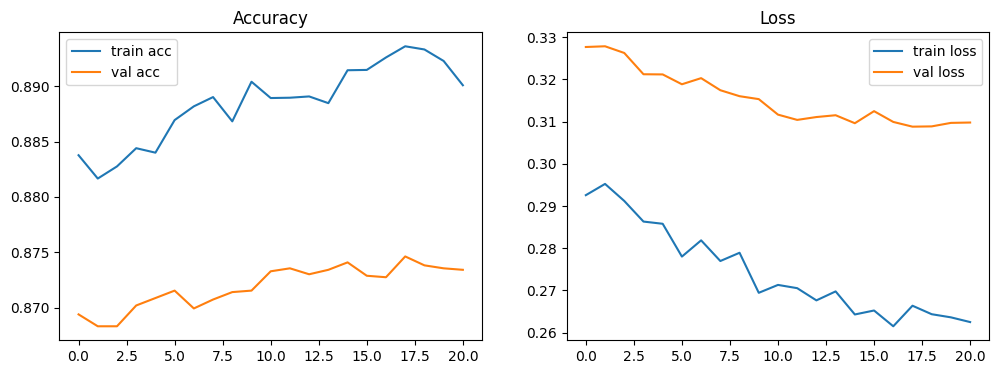

117/117 [==============================] - 21s 171ms/step - loss: 0.3333 - accuracy: 0.8678 - precision: 0.8710 - recall: 0.8642

✅ Test Accuracy: 0.868
✅ Test Precision: 0.871
✅ Test Recall: 0.864
1/2 [==============>...............] - ETA: 0s

2025-10-31 20:06:26.520546: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19267584 bytes after encountering the first element of size 19267584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 [==============================] - 2s 2s/step


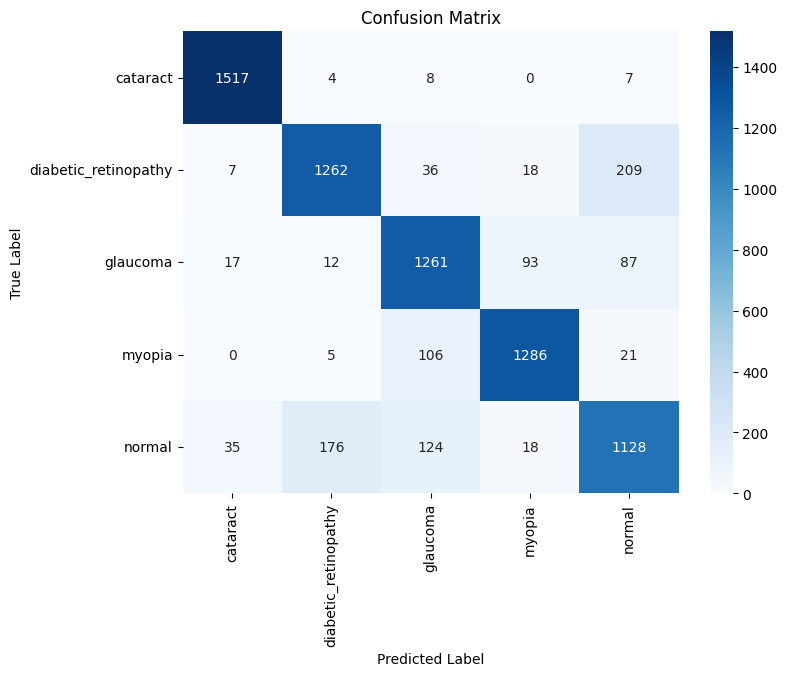


Classification Report:

                      precision    recall  f1-score   support

            cataract       0.96      0.99      0.97      1536
diabetic_retinopathy       0.86      0.82      0.84      1532
            glaucoma       0.82      0.86      0.84      1470
              myopia       0.91      0.91      0.91      1418
              normal       0.78      0.76      0.77      1481

            accuracy                           0.87      7437
           macro avg       0.87      0.87      0.87      7437
        weighted avg       0.87      0.87      0.87      7437



In [10]:


# Freeze all layers except the last 120
for layer in base_model.layers[:-180]:
    layer.trainable = False

for layer in base_model.layers[-180:]:
    layer.trainable = True
    
model.compile(
    optimizer=Adam(learning_rate=7e-8),
    loss='categorical_crossentropy',
    metrics=metrics
)

history_finetune4 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2)
    ]
)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_finetune4.history['accuracy'], label='train acc')
plt.plot(history_finetune4.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history_finetune4.history['loss'], label='train loss')
plt.plot(history_finetune4.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss')
plt.show()


# ==========================================
# 🧪 EVALUATION ON TEST SET
# ==========================================
test_loss, test_acc, test_prec, test_rec = model.evaluate(test_ds)
print(f"\n✅ Test Accuracy: {test_acc:.3f}")
print(f"✅ Test Precision: {test_prec:.3f}")
print(f"✅ Test Recall: {test_rec:.3f}")

# ==========================================
# 🧩 CONFUSION MATRIX + REPORT
# ==========================================
y_true, y_pred = [], []
for x, y in test_ds:
    preds = model.predict(x)
    y_true.extend(tf.argmax(y, axis=1).numpy())
    y_pred.extend(tf.argmax(preds, axis=1).numpy())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))



